In [156]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import pandas_datareader.data as pdr

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import feature_column
from tensorflow.keras import layers

from datetime import datetime, timezone,timedelta

from ta.utils import dropna
from ta.volatility import BollingerBands, AverageTrueRange
from ta.momentum import KAMAIndicator, PercentagePriceOscillator, PercentageVolumeOscillator, ROCIndicator, RSIIndicator, StochasticOscillator
from ta.trend import MACD, ADXIndicator, AroonIndicator
from ta.volume import OnBalanceVolumeIndicator, AccDistIndexIndicator

In [2]:
dataframe = pd.read_csv("./ethusd.csv", usecols=[4], names=["price"], skiprows=1)
dataframeNew = pd.read_csv("./ethusd.csv", usecols=[4,7,8,9,10,11,12,13,14,15,16,17,18,19], names=['close','kama','ppo','pvo','roc','macd','rsi','obv','adi','adx','aroon','stoo','boll_mavg','atr'], skiprows=50)

In [3]:
dataframe.head()

,price
0,2.772120
1,0.753325
2,0.701897
3,0.708448
4,1.067860


In [4]:
dataframeNew.head()

,close,kama,ppo,pvo,roc,macd,rsi,obv,adi,adx,aroon,stoo,boll_mavg,atr
0,0.736223,0.923450,-13.579212,-12.723064,-21.343949,-0.140973,28.901290,-6504737.0,-5.660970e+06,27.838781,-96.0,5.838193,0.982748,0.122810
1,0.785964,0.914750,-13.673968,-15.242475,-10.239350,-0.139402,33.370985,-6135117.0,-5.306283e+06,28.670630,-80.0,22.793951,0.957254,0.119625
2,0.720839,0.899199,-14.215479,-16.668281,-23.673087,-0.141778,30.653805,-6548918.0,-5.700917e+06,29.395340,-88.0,3.423733,0.930964,0.116231
3,0.582886,0.856690,-15.830843,-6.140717,-35.747127,-0.153029,25.851933,-7869808.0,-6.617209e+06,30.868068,-92.0,5.286625,0.897987,0.119972
4,0.661146,0.840180,-16.298015,-3.083363,-24.373993,-0.153856,32.328235,-6955816.0,-5.931692e+06,32.235600,-92.0,26.003837,0.870718,0.119795


In [5]:
dataframeNew

,close,kama,ppo,pvo,roc,macd,rsi,obv,adi,adx,aroon,stoo,boll_mavg,atr
0,0.736223,0.923450,-13.579212,-12.723064,-21.343949,-0.140973,28.901290,-6.504737e+06,-5.660970e+06,27.838781,-96.0,5.838193,0.982748,0.122810
1,0.785964,0.914750,-13.673968,-15.242475,-10.239350,-0.139402,33.370985,-6.135117e+06,-5.306283e+06,28.670630,-80.0,22.793951,0.957254,0.119625
2,0.720839,0.899199,-14.215479,-16.668281,-23.673087,-0.141778,30.653805,-6.548918e+06,-5.700917e+06,29.395340,-88.0,3.423733,0.930964,0.116231
3,0.582886,0.856690,-15.830843,-6.140717,-35.747127,-0.153029,25.851933,-7.869808e+06,-6.617209e+06,30.868068,-92.0,5.286625,0.897987,0.119972
4,0.661146,0.840180,-16.298015,-3.083363,-24.373993,-0.153856,32.328235,-6.955816e+06,-5.931692e+06,32.235600,-92.0,26.003837,0.870718,0.119795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,1935.601074,1783.478243,8.871710,-6.680036,9.477529,149.944851,69.022841,1.234941e+12,1.529547e+12,31.465398,88.0,78.333547,1772.453857,122.700049
1973,1781.992920,1783.446555,7.908499,-3.963375,2.164234,134.203235,56.186023,1.192531e+12,1.535137e+12,29.766826,76.0,44.192242,1785.793817,139.351985
1974,1570.203979,1764.869591,6.129902,0.269751,-11.974114,103.445835,44.027908,1.140501e+12,1.532573e+12,29.455699,76.0,29.107055,1781.258539,158.194842
1975,1626.575684,1758.076427,4.911708,-0.997715,-11.768542,82.666174,47.296920,1.171830e+12,1.537453e+12,29.166796,76.0,37.681408,1782.849188,161.178413


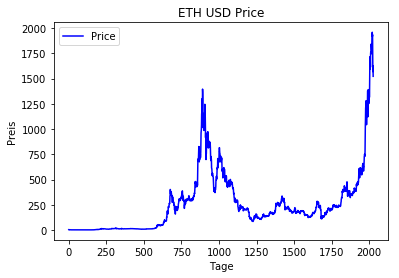

In [6]:
prices = dataframe['price'].to_numpy()

days = range(1, len(prices) + 1)

plt.plot(days, prices, 'blue', label='Price')
plt.title('ETH USD Price')
plt.xlabel('Tage')
plt.ylabel('Preis')
plt.legend()

plt.show()

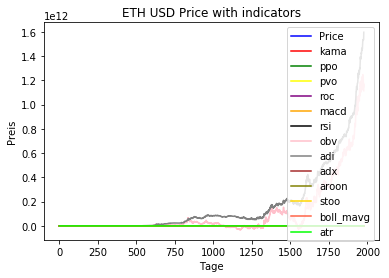

In [7]:
prices = dataframeNew['close'].to_numpy()
kama = dataframeNew['kama'].to_numpy()
ppo = dataframeNew['ppo'].to_numpy()
pvo = dataframeNew['pvo'].to_numpy()
roc = dataframeNew['roc'].to_numpy()
macd = dataframeNew['macd'].to_numpy()
rsi = dataframeNew['rsi'].to_numpy()
obv = dataframeNew['obv'].to_numpy()
adi = dataframeNew['adi'].to_numpy()
adx = dataframeNew['adx'].to_numpy()
aroon = dataframeNew['aroon'].to_numpy()
stoo = dataframeNew['stoo'].to_numpy()
boll_mavg = dataframeNew['boll_mavg'].to_numpy()
atr = dataframeNew['atr'].to_numpy()

days = range(1, len(prices) + 1)

plt.plot(days, prices, 'blue', label='Price')
plt.plot(days, kama, 'red', label='kama')
plt.plot(days, ppo, 'green', label='ppo')
plt.plot(days, pvo, 'yellow', label='pvo')
plt.plot(days, roc, 'purple', label='roc')
plt.plot(days, macd, 'orange', label='macd')
plt.plot(days, rsi, 'black', label='rsi')
plt.plot(days, obv, 'pink', label='obv')
plt.plot(days, adi, 'grey', label='adi')
plt.plot(days, adx, 'brown', label='adx')
plt.plot(days, aroon, 'olive', label='aroon')
plt.plot(days, stoo, 'gold', label='stoo')
plt.plot(days, boll_mavg, 'tomato', label='boll_mavg')
plt.plot(days, atr, 'lime', label='atr')
plt.title('ETH USD Price with indicators')
plt.xlabel('Tage')
plt.ylabel('Preis')
plt.legend()

plt.show()

In [8]:
features = []
labels = []

for i in range(20, len(prices)):
    if (i+1 <= len(prices)-1):
        feature = prices[i-20:i]
        normalized_prices = []
        
        for q in range(20):
            normalized_prices.append(feature[q] / feature[0])
        
        features.append(normalized_prices)
        
        next_price = prices[i]
        
        if (next_price > prices[i+1]):
            labels.append([1])
        else:
            labels.append([0])
            

In [129]:
raw_features = []
raw_labels = []

for i in range(20, len(prices)):
    if (i+1 <= len(prices)-1):
        feature = []
        prices_n = prices[i-20:i]
        kama_n = kama[i-20:i]
        ppo_n = ppo[i-20:i]
        pvo_n = pvo[i-20:i]
        roc_n = roc[i-20:i]
        macd_n = macd[i-20:i]
        rsi_n = rsi[i-20:i]
        obv_n = obv[i-20:i]
        adi_n = adi[i-20:i]
        adx_n = adx[i-20:i]
        aroon_n = aroon[i-20:i]
        stoo_n = stoo[i-20:i]
        boll_mavg_n = boll_mavg[i-20:i]
        atr_n = atr[i-20:i]
        normalized_prices = []
        normalized_kama = []
        normalized_ppo = []
        normalized_pvo = []
        normalized_roc = []
        normalized_macd = []
        normalized_rsi = []
        normalized_obv = []
        normalized_adi = []
        normalized_adx = []
        normalized_aroon = []
        normalized_stoo = []
        normalized_boll_mavg = []
        normalized_atr= []
    
        for q in range(20):
            normalized_prices.append(prices_n[q] / prices_n[0])
            normalized_kama.append(kama_n[q] / kama_n[0])
            normalized_ppo.append(ppo_n[q] / ppo_n[0])
            normalized_pvo.append(pvo_n[q] / pvo_n[0])
            normalized_roc.append(roc_n[q] / roc_n[0])
            normalized_macd.append(macd_n[q] / macd_n[0])
            normalized_rsi.append(rsi_n[q] / rsi_n[0])
            #normalized_obv.append(obv_n[q] / obv_n[0])
            #normalized_adi.append(adi_n[q] / adi_n[0])
            normalized_adx.append(adx_n[q] / adx_n[0])
            normalized_aroon.append(aroon_n[q] / aroon_n[0])
            #normalized_stoo.append(stoo_n[q] / stoo_n[0])
            normalized_boll_mavg.append(boll_mavg_n[q] / boll_mavg_n[0])
            normalized_atr.append(atr_n[q] / atr_n[0])
            
        feature.append(normalized_prices)
        feature.append(normalized_kama)
        feature.append(normalized_ppo)
        feature.append(normalized_pvo)
        feature.append(normalized_roc)
        feature.append(normalized_macd)
        feature.append(normalized_rsi)
        #feature.append(normalized_obv)
        #feature.append(normalized_adi)
        feature.append(normalized_adx)
        feature.append(normalized_aroon)
        #feature.append(normalized_stoo)
        feature.append(normalized_boll_mavg)
        feature.append(normalized_atr)
    
        
        raw_features.append(feature)
        
        next_price = prices[i]

        for j in range(1):
            if (next_price > prices[i+1]):
                raw_labels.append(1)
            else:
                raw_labels.append(0)

In [132]:
features = []
labels = []

for i in range(len(raw_features)):
    features.append([list(a) for a in zip(*raw_features[i])])
    labels.append(raw_labels[i])

In [133]:
for i in range(1):
    print('features', features[i])
    print('----')
    print('----')
    print('labels', labels[i])
    print('----')
    
print(len(features))
print(len(labels))

features [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0675624097589997, 0.9905782356621373, 1.0069780079528525, 1.1980192383505721, 0.4797308130784857, 0.9888584401822896, 1.1546538293030844, 1.0298809422070982, 0.8333333333333334, 0.9740591582212972, 0.9740633100482244], [0.9791041573001659, 0.9737385537821478, 1.0468559272907407, 1.3100838688360288, 1.109124054381061, 1.005712481745037, 1.0606379405046231, 1.055913307112459, 0.9166666666666666, 0.9473070705031488, 0.9464267143157753], [0.7917247899074058, 0.9277050756965809, 1.1658145531037796, 0.4826445058523144, 1.674813203482962, 1.0855194458771875, 0.8944906195776303, 1.1088153241755978, 0.9583333333333334, 0.9137509468351793, 0.9768944286727343], [0.8980241041097603, 0.9098272157728587, 1.200217966249689, 0.24234441019782732, 1.1419626727504482, 1.091390760941195, 1.1185740973771099, 1.1579386257342268, 0.9583333333333334, 0.8860040462067778, 0.9754471363894704], [1.0032884058226923, 0.902309052959614, 1.16209974

In [134]:
def numpy_to_ds(features, labels, batch_size):
    return tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

In [135]:
dataset = numpy_to_ds(features, labels, 1)

In [136]:
dataset = dataset.shuffle(len(features))

In [137]:
DATASET_SIZE = len(features)

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
val_ds = dataset.skip(test_size)
test_ds = dataset.take(test_size)

In [138]:
text_batch, label_batch = next(iter(train_ds))
print(text_batch, label_batch)

tf.Tensor(
[[[1.         1.         1.         1.         1.         1.
   1.         1.         1.         1.         1.        ]
  [0.9887071  1.00300641 1.19037434 0.71421538 0.81794731 1.19400707
   0.95893353 0.9933658  1.         1.0056179  0.9782498 ]
  [1.13766285 1.04273986 2.61116064 4.92999549 2.4110407  2.65684817
   1.22564386 1.08071524 1.11764706 1.02025321 1.21043633]
  [1.13955029 1.07387675 3.6754432  7.04670428 1.90426482 3.78945359
   1.22793098 1.16887221 1.17647059 1.03502515 1.24313087]
  [1.12693888 1.08811786 4.33693779 7.81817537 1.73009541 4.52150281
   1.18526684 1.23699956 1.17647059 1.04879929 1.24832478]
  [1.17073661 1.11283436 5.14164601 8.79817258 2.01778944 5.43294846
   1.24249019 1.31628003 1.29411765 1.06453003 1.29081614]
  [1.20217283 1.14825629 5.93627182 9.34600311 1.71546787 6.36464693
   1.27843977 1.40211923 1.35294118 1.07957549 1.34876897]
  [1.14461746 1.15523848 6.01676212 9.13172741 1.30061616 6.5103218
   1.10119031 1.45304051 1.352941

In [139]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [147]:
model = tf.keras.Sequential([
  layers.LSTM(64, input_shape=(20, 11)),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

model.summary()

Epoch 1/10
1369/1369 [==============================] - 15s 10ms/step - loss: 0.7228 - binary_accuracy: 0.4978 - val_loss: 0.6921 - val_binary_accuracy: 0.5291
Epoch 2/10
1369/1369 [==============================] - 13s 9ms/step - loss: 0.7016 - binary_accuracy: 0.4914 - val_loss: 0.6883 - val_binary_accuracy: 0.5374
Epoch 3/10
1369/1369 [==============================] - 12s 9ms/step - loss: 0.6973 - binary_accuracy: 0.5011 - val_loss: 0.6857 - val_binary_accuracy: 0.5534
Epoch 4/10
1369/1369 [==============================] - 12s 9ms/step - loss: 0.6918 - binary_accuracy: 0.5190 - val_loss: 0.6832 - val_binary_accuracy: 0.5610
Epoch 5/10
1369/1369 [==============================] - 12s 9ms/step - loss: 0.6884 - binary_accuracy: 0.5290 - val_loss: 0.6811 - val_binary_accuracy: 0.5534
Epoch 6/10
1369/1369 [==============================] - 12s 9ms/step - loss: 0.6819 - binary_accuracy: 0.5495 - val_loss: 0.6791 - val_binary_accuracy: 0.5540
Epoch 7/10
1369/1369 [=======================

In [148]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

391/391 [==============================] - 1s 2ms/step - loss: 0.6703 - binary_accuracy: 0.5754
Loss:  0.6702743768692017
Accuracy:  0.5754475593566895


In [149]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

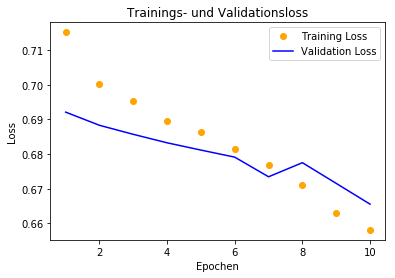

In [150]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'o', color='orange', label='Training Loss')
plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
plt.title('Trainings- und Validationsloss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()

plt.show()

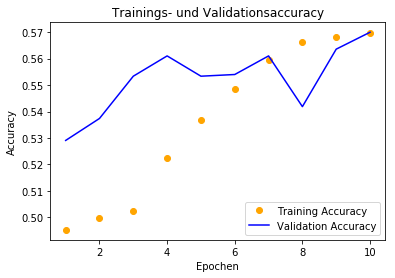

In [151]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'o', color='orange', label='Training Accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
plt.title('Trainings- und Validationsaccuracy')
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [152]:
feature_batch, label_batch = next(iter(test_ds))
print(feature_batch)

model.predict(feature_batch)

tf.Tensor(
[[[ 1.          1.          1.          1.          1.
    1.          1.          1.          1.          1.
    1.        ]
  [ 0.99671566  1.0001655   0.91313474  1.11987682  0.57503779
    0.9092562   0.99263204  0.94849856  1.          1.00137582
    0.96079528]
  [ 0.97940686  0.99993241  0.85383353  1.10610995  0.86152322
    0.8458135   0.95278944  0.9062373   0.92307692  1.00317979
    0.9260477 ]
  [ 0.96743422  0.99952525  0.81109293  0.87024741  0.40579468
    0.79892974  0.92512838  0.87210115  0.84615385  1.00376655
    0.89031881]
  [ 0.78665337  0.98095843  0.9732162  -0.37253775 -2.33462215
    0.94124702  0.62844813  0.89686233  1.84615385  0.99403398
    1.05856993]
  [ 0.77948877  0.95076657  1.10457742 -0.93223238 -2.30612938
    1.04947951  0.61996266  0.92962547  1.53846154  0.97909597
    1.04195723]
  [ 0.73543125  0.8929759   1.2543973  -0.86423316 -2.74936356
    1.16817163  0.5690775   0.95572554  1.61538462  0.96536415
    1.0373818 ]
  [ 0.67024

array([[-0.32886577]], dtype=float32)

In [158]:
end = datetime.today()
start = datetime.today() - timedelta(days=46)
ETH = pdr.DataReader('ETH-USD','yahoo',start,end)

df = pd.DataFrame(data=ETH)

kama_indicator = KAMAIndicator(close = df["Close"], window = 10, pow1 = 2, pow2 = 30, fillna = False)
df['kama'] = kama_indicator.kama()
ppo_indicator = PercentagePriceOscillator(close = df["Close"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
df['ppo'] = ppo_indicator.ppo()
pvo_indicator = PercentageVolumeOscillator(volume = df["Volume"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
df['pvo'] = pvo_indicator.pvo()
roc_indicator = ROCIndicator(close = df["Close"], window = 12, fillna = False)
df['roc'] = roc_indicator.roc()
macd_indicator = MACD(close = df["Close"], window_slow = 20, window_fast = 12, window_sign = 9, fillna = False)
df['macd'] = macd_indicator.macd()
rsi_indicator = RSIIndicator(close = df["Close"], window = 14, fillna = False)
df['rsi'] = rsi_indicator.rsi()
#obv_indicator = OnBalanceVolumeIndicator(close = df["Close"], volume = df["Volume"], fillna = False)
#df['obv'] = obv_indicator.on_balance_volume() 
#adi_indicator = AccDistIndexIndicator(high = df["High"], low = df["Low"], close = df["Close"], volume = df["Volume"], fillna = False)
#df['adi'] = adi_indicator.acc_dist_index() 
adx_indicator = ADXIndicator(high = df["High"], low = df["Low"], close = df["Close"], window = 14, fillna = False)
df['adx'] = adx_indicator.adx() 
aroon_indicator = AroonIndicator(close = df["Close"], window = 20, fillna = False)
df['aroon'] = aroon_indicator.aroon_indicator()
#stoo_indicator = StochasticOscillator(high = df["High"], low = df["Low"], close = df["Close"], window = 14, smooth_window = 3, fillna = False)
#df['stoo'] = stoo_indicator.stoch()
boll_indicator = BollingerBands(close = df["Close"], window = 20, window_dev = 2, fillna = False)
df['boll_mavg'] = boll_indicator.bollinger_mavg()
atr_indicator = AverageTrueRange(high = df["High"], low = df["Low"], close = df["Close"], window = 14, fillna = False)
df['atr'] = atr_indicator.average_true_range()

df = df[27:47]
df =  df.drop(df.columns[[0, 1, 2, 4, 5]], axis=1)

example = df.to_numpy()
example
#example_dataset = numpy_to_ds(features, labels, 1)
#dataVar_tensor = tf.constant(dataVar, dtype = tf.float32, shape=[15780,9])
#model.predict(tf.reshape(example, [1, 11, 20]))
#tf.reshape(example, [11, 20])

/usr/local/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


array([[ 1.93744922e+03,  1.72359850e+03,  6.08696606e+00,
        -5.17576493e+00,  1.54723552e+01,  8.18282333e+01,
         7.37810415e+01,  4.24750688e+01,  9.00000000e+01,
         1.68469597e+03,  1.23201357e+02],
       [ 1.96016479e+03,  1.75768359e+03,  6.23969986e+00,
        -7.02310094e+00,  2.14304955e+01,  8.47583997e+01,
         7.46882542e+01,  4.22958922e+01,  9.50000000e+01,
         1.71389844e+03,  1.19605728e+02],
       [ 1.91953406e+03,  1.77632360e+03,  6.03979446e+00,
        -6.18008345e+00,  9.90012430e+00,  8.33784708e+01,
         7.00212398e+01,  4.25411077e+01,  9.00000000e+01,
         1.74412583e+03,  1.25759248e+02],
       [ 1.93560107e+03,  1.79243467e+03,  5.85466028e+00,
        -8.34685486e+00,  9.47752939e+00,  8.20420357e+01,
         7.07983096e+01,  4.27688078e+01,  8.50000000e+01,
         1.77245386e+03,  1.22768693e+02],
       [ 1.78199292e+03,  1.79221190e+03,  4.90098525e+00,
        -4.91002182e+00,  2.16423416e+00,  7.08141473e+01,
  